# Getting Started With Fractional Cover Data  

| Authors:  | Claire Krause, Arapaut Sivaprasad|
|----------|----------------|
| Created: | May 14, 2018 |
| Last edited: | May 15, 2018 |

## Retrieve and plot the FC data from Landsats 5, 7 and 8  

**Background:** Data from three Landsats (5,7 and 8) are available to access within DEA. The code snippets in this doc will let you retrieve and plot the Fractional Cover (FC) data for **lsN_fc_albers** and **lsN_fc_albers**, where N is 5, 7 or 8 to denote the satellite.

**What does this document do?**

- Show how to open a datacube to retrieve the data for various time points and geo-coordinates.

- Compare multiple scenes side-by-side as Fractional Cover (FC) images for three bands and errors.

- Plot an enlarged scene for each band.

**How to use this document:**

A basic understanding of *any* programming language is desirable, so that the code will make sense, but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data. 

This doc applies to the following Landsats and Fractional Cover bands:

- Landsat 5
- Landsat 7
- Landsat 8
- PV - Photosythetic vegetation
- NPV - Non-Photosythetic vegetation
- BS - Bare Soil
- UE - Unmixing Error


## What is Fractional Cover? [[1](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF)]
Source: https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF

The Fractional Cover product is derived from Geoscience Australia's Australian Reflectance Grid 25 (ARG25) product and provides a 25m scale fractional cover representation of the proportions of green or photosynthetic vegetation, non-photosynthetic vegetation, and bare surface cover across the Australian continent. The green fraction includes leaves and grass, the non-photosynthetic includes branches, dry grass and dead leaf litter, and the bare soil fraction includes bare soil or rock.

Fractional cover data can be used to identify large scale patterns and trends and inform evidence based decision making and policy on topics including wind and water erosion risk, soil carbon dynamics, land management practices and rangeland condition.

The fractional cover unmixing algorithm uses the spectral signature for a picture element (pixel) to break it up into three parts or fractions. This is based on field work identifying the spectral characteristics of each of the fractions.  



## How to retrieve and plot the data
Let us go through the process step by step. This is a Python program or a HTML page derived from one.  

Given below are code snippets that you can execute to perform various actions such as retrieve, display and plot the data. 

In [131]:
%matplotlib inline
import datacube
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np
import matplotlib.gridspec as gridspec

### See what products are currently available
The **list_products** method in the Datacube class displays the names and details of all available products. A product may be defined as the data collected by a particular satellite and reformatted. For example, **ls8_fc_albers**, is a set of data collected by the Landsat 7 as per the Australian Albers projected coordinate system. 

Given below are the products that are of interest to us in the context of this document. The code given below the list will let you see ALL products in the datacube.

|id 	| name 	| description|
|-|-|-|
|69 		| ls5_fc_albers 	| Landsat 5 Fractional Cover 25 metre, 100km til...|
|70 	| ls7_fc_albers 	| Landsat 7 Fractional Cover 25 metre, 100km til...|
|71 	| ls8_fc_albers 	| Landsat 8 Fractional Cover 25 metre, 100km til...|


#### Code to display the products

In [132]:
dc = datacube.Datacube(app='dc-metadata')
products = dc.list_products()
display_columns = ['name', 'description']
display_rows = [1]
dc_products = products[display_columns]
#dc_products # Activate this line to see all products

### Specify the *query* with the coordinates and date range

- **lat/lon:** Latitude and longitude of the area. e.g. Canberra = 'lat': (-35.25, -35.35), 'lon': (149.05, 149.17)
- **time:** Date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swath boundary, it may be captured in two passes and so there could be two images within the 16 day period.
    - You must know [the date(s) for which data is available](https://data.dea.gadevs.ga/ls7_nbar_scene) for each satellite/product, so that the query can be specified correctly. 
- **scene:** The index of the scene to be plotted. If the date range is < 16 days there may only be one scene, and the index must be specified as 0.

In [133]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2014-01-01', '2014-01-31')
        }
scene = 1

### Now we load and look at some data
We will focus on data from the Landsats (5,7 and 8) for this demonstration. Multiple scenes are sometimes acquired by the satellite on the same day. We want to group these together, and will use **group_by='solar_day'** to do this. To load in the data, we need only to provide the geo-coordinates and time range.

### Create a data scene object
The return value from the load command below is an **xarray** object, which has two core data structures:

- **DataArray** is a labeled, N-dimensional array. 
- **Dataset** is a multi-dimensional, in-memory array database. It is a dict-like container of DataArray objects aligned along any number of shared dimensions, and serves a similar purpose in xarray to the **pandas.DataFrame**.

The bands that are in the data are as follows: **[[2](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover)]**

- **Band1 (BS):**  - bare (bare ground, rock, disturbed), 
- **Band2 (PV):**  - green vegetation, 
- **Band3 (NPV):** - non green vegetation (litter, dead leaf and branches), 
- **Band4 (UE):**  - Mask Layer, also called Unmixing Error or UE. Its values are as given below. 
    - 0 indicates no-data. 
    - 1 indicates good data. 
    - 2 indicates unmixing error was excessive, 
    - 3 indicates water was detected in the pixel. 
    - 4 indicates the pixel had cast shadow. 
    - 5 indicates the pixel incidence or exidence angle exceeded 80 degrees. 
    - 6 indicates a cloud shadow was detected. 
    - 7 indicates a cloud was detected.
    
    (*Question: There are values for UE above 7, but no explanation of those could be found. Any idea?*)


In [134]:
ds = dc.load(product='ls8_fc_albers', group_by='solar_day', **query)

### Function to plot one image from the data

In [135]:
'''
    Last modified: April 2018
    Author: Mike Barnes
    Modified by: Claire Krause, Cate Kooymans, Robbi Bishop-Taylor, Sivaprasad Arapaut

Parameters for three_band_image():

Inputs:

    ds - dataset containing the bands to be plotted
    bands - list of three bands to be plotted

Optional:

    time - Index value of the time dimension of ds to be plotted.
        This index refers to the scenes captured, depending on your date range.
    figsize - dimensions for the output figure.
    contrast_enhance - determines the transformation for plotting onto RGB. If contrast_enhance = true, exposure.equalize_hist is used to transform the data. Else, the data are standardised relative to reflectance = 5000.
    title - string for the plot title. If nothing is given, it will print the names of the bands being plotted.
    projection - options are 'projected' or 'geographic'; determines if the image is in degrees or northings.
        The terms easting and northing are geographic Cartesian coordinates for a point. Easting refers to the eastward-measured distance (or the x-coordinate), while northing refers to the northward-measured distance (or the y-coordinate). Easting and northing coordinates are commonly measured in metres from the axes of some horizontal datum.
'''
def three_band_image(ds, bands, time=0, figsize=[10, 10], contrast_enhance=True, title='My Plot', projection='projected'):

    # Get the number of scenes and the number of x and y coordinates
    t, y, x = ds[bands[0]].shape

    # Initialise a numpy.ndarray class object with 0's
    rawimg = np.zeros((y, x, 3), dtype=np.float32)

    # Populate the rawimg array with actual values. These are taken from all specified bands
    for i, colour in enumerate(bands):
        rawimg[:, :, i] = ds[colour][time].values

    # If any value is recorded as -999, then change it to a NaN to make it an invalid data point
    rawimg[rawimg == -999] = np.nan
    
    # Enhance the picture quality by applying 'histogram_equalisation'
    if contrast_enhance:
        img_toshow = exposure.equalize_hist(rawimg, mask=np.isfinite(rawimg))
    else:
        img_toshow = rawimg / 5000
        
    # Plot the data
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_toshow)
    
    # Build the X and Y axes
    ax = plt.gca()

    ax.set_title(str(ds.time[time].values), fontweight='bold', fontsize=16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    
    ax.set_xlabel('Eastings', fontweight='bold')
    ax.set_ylabel('Northings', fontweight='bold')


### Plot all bands
The plots below display the three bands plus the unmixing error data ('UE') in different colors. Plots given below it are individual bands as enlarged figures.

The bare soil, green vegetation and non-green vegetation end menbers are calculated using models linked to an intensive field sampling program whereby more than 600 sites covering a wide variety of vegetation, soil and climate types were sampled to measure overstorey and ground cover


<Figure size 432x288 with 0 Axes>

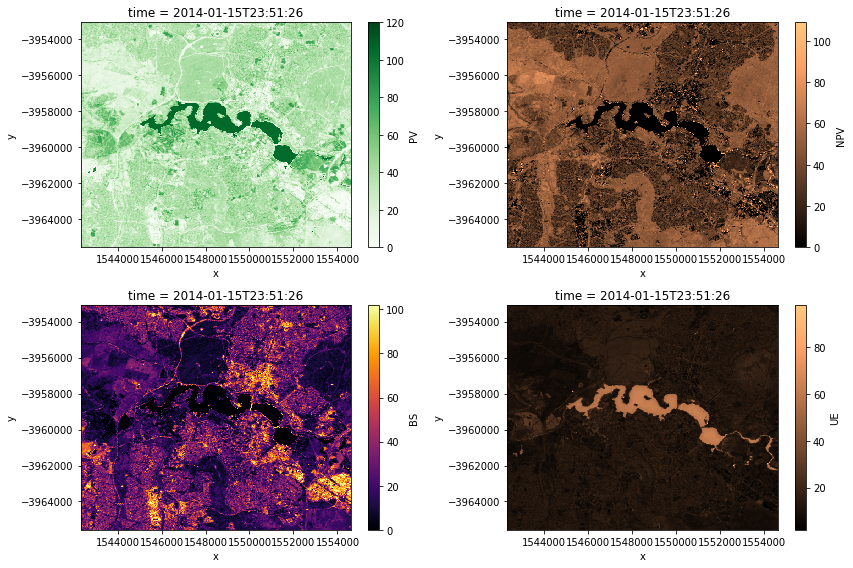

In [136]:
plt.clf()
plt.figure(figsize=(12,8))
#set up a grid of 3 images for better presentation
gs = gridspec.GridSpec(2,2)

#_______________________________________________________________#
ax1=plt.subplot(gs[0,0])
ds.PV.isel(time=scene).plot(cmap='Greens')

ax2=plt.subplot(gs[1,0])
ds.BS.isel(time=scene).plot(cmap='inferno')

ax3=plt.subplot(gs[0,1])
ds.NPV.isel(time=scene).plot(cmap='copper')

ax4=plt.subplot(gs[1,1])
ds.UE.isel(time=scene).plot(cmap='copper')

plt.tight_layout()
plt.show()

### Plot an image of Photosynthetic Vegetation (PV)
The intensity of green in the plot indicates the percentage coverage, as shown in the scale to the right. Since water is considerd as PV, the lake in the middle appears as intense green.

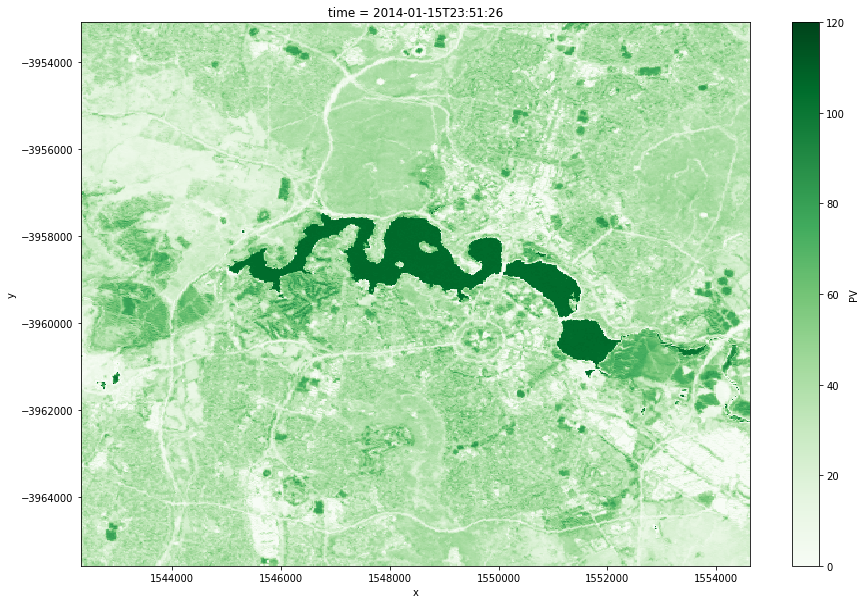

In [137]:
plt.figure(figsize=(15,10))
ds.PV.isel(time = scene).plot(cmap='Greens');

### Plot an image of Non-Photosynthetic Vegetation (NPV)
The intensity of colour in the plot indicates the percentage coverage, as shown in the scale to the right. Since water is considerd as 100% PV, the lake in the middle appears as black.

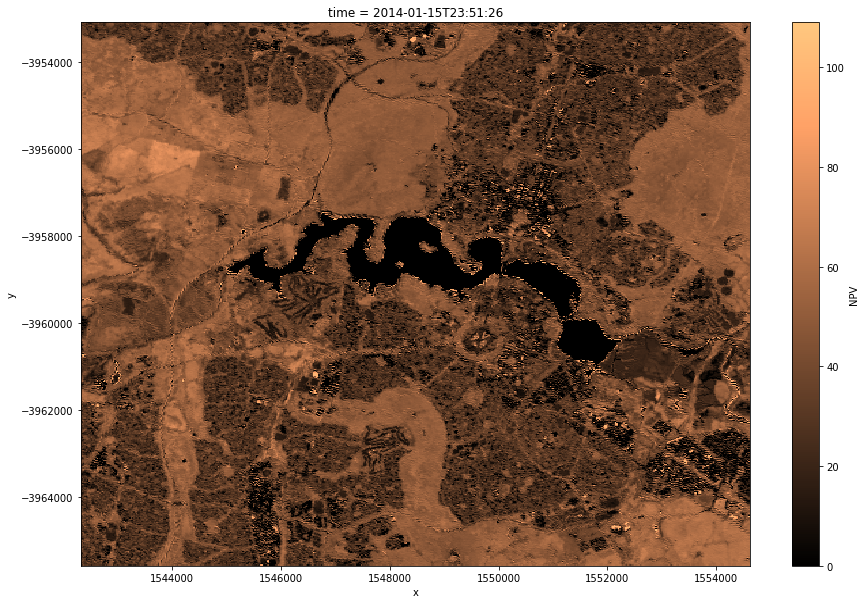

In [138]:
plt.figure(figsize=(15,10))
ds.NPV.isel(time = scene).plot(cmap='copper');

### Plot an image of Bare Soil (BS)
The intensity of colour in the plot indicates the percentage coverage, as shown in the scale to the right. Since water is considerd as 100% PV, the lake in the middle appears as black.

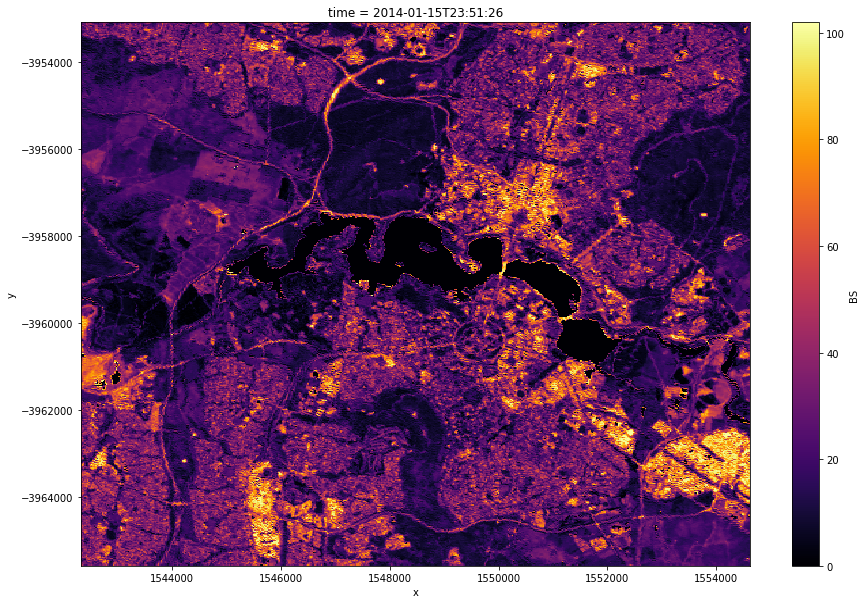

In [139]:
plt.figure(figsize=(15,10))
ds.BS.isel(time = scene).plot(cmap='inferno');

### Plot an image of Undefined Errors (UE)
The intensity of colour in the plot indicates the severity of errors. Unsure why the water areas appear orange. (*Question: Does it indicate bigger errors over water?*)

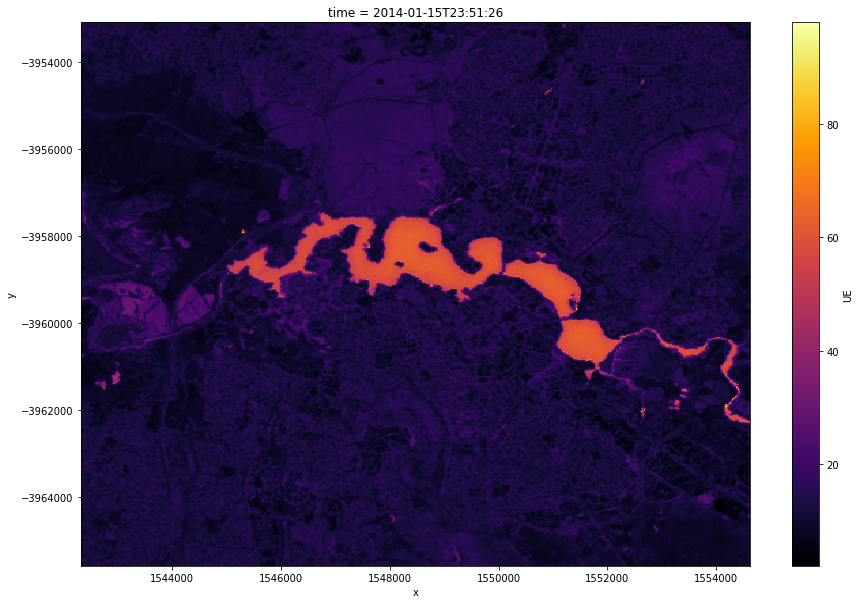

In [140]:
plt.figure(figsize=(15,10))
ds.UE.isel(time = scene).plot(cmap='inferno');